In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from macro import calcEnergy, calcMag
import tensorflow as tf
import seaborn as sns
import os
from math import ceil
import csv
from pathlib import Path

2023-09-17 18:29:19.449396: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-17 18:29:19.496677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-17 18:29:19.497462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 18:29:20.515872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Convolutional Layer

Test for the filter: How many neighbours each cell has?

In [2]:
def get_neighbour_filter():
    neighb_filter= tf.keras.layers.Conv2D(1, (3, 3), padding='same',use_bias=False)
    filter_weights = np.ones((3,3))
    filter_weights[1][1] = 0
    neighb_filter.build((3, 3, 1))
    neighb_filter.set_weights([filter_weights.reshape((3,3,1,1))])
    return neighb_filter

<Axes: >

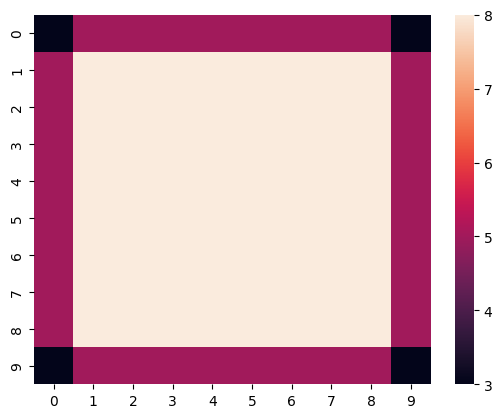

In [3]:
neighb_filter = get_neighbour_filter()
ones = np.ones((10, 10))
ones = ones.reshape(1, ones.shape[0], ones.shape[1], 1).astype('float32')
results = neighb_filter(ones)[0].numpy().squeeze()
sns.heatmap(results)

# Energy and Magnetization time series

In [4]:
def time_series(folder):

    try:
        folder_path = Path(folder)
        reader = csv.DictReader(open(folder_path / "parameters.csv"))
        par_dict = next(reader) 
    except:
        raise ValueError("Invalid folder provided")

    n_rows = int(par_dict['Simulatiton Number'])
    n_cols = 3
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (9, n_rows * 2))

    fig.suptitle(f"Temperature: {par_dict['Temperature']} External Field: {par_dict['Magnetic Field']}", fontsize=18)
    
    plot_columns = ["Maze", "Energy", "Magnetization"]
    for ax, col in zip(axes[0], plot_columns):
        ax.set_title(col)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    for index in range(n_rows):
        # Maze Plot
        data = np.load(folder_path / f"output{index+1}" / "final.npy")
        axes[index][0].imshow(data)

        # Statistics
        columns = ['iter','energy','mag']
        df = pd.read_csv(folder_path / f"output{index+1}" / "data.csv", header=None, names=columns).set_index('iter')
        
        # Energy plot
        axes[index][1].plot(df.energy)
        
        # Magnetization plot
        axes[index][2].plot(df.mag)




## High temperature

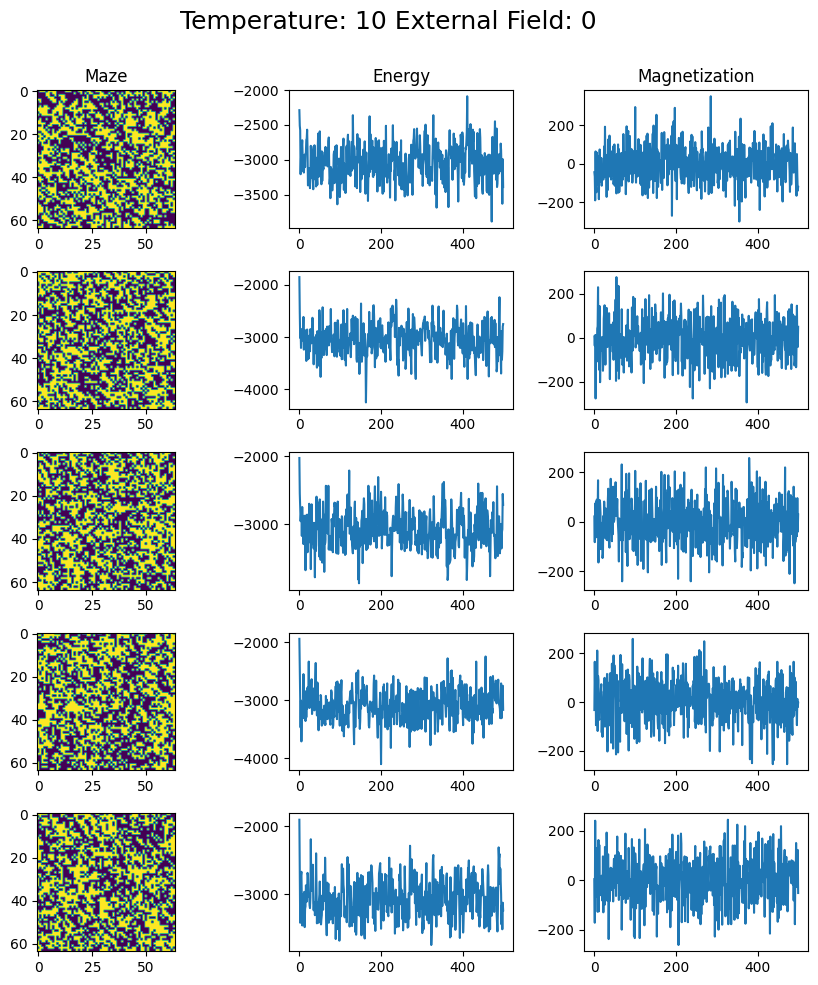

In [5]:
time_series("Rust/Demo/High")

## Low Temperature

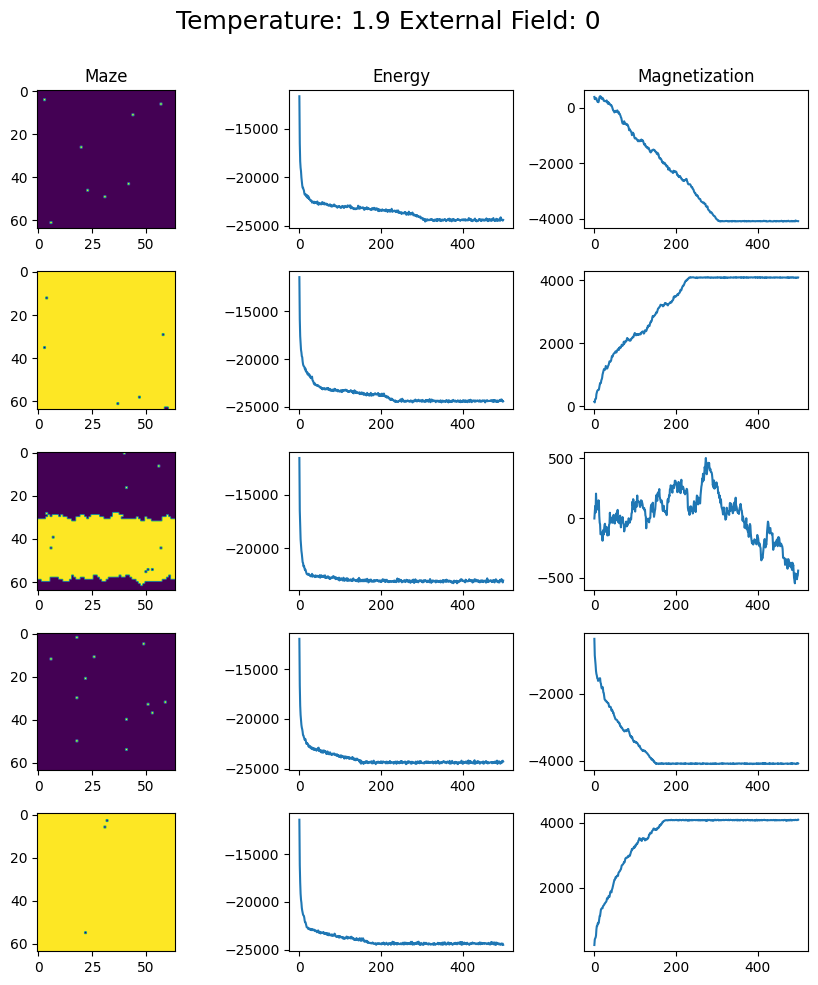

In [6]:
time_series("Rust/Demo/Low")

## Around critical temperature

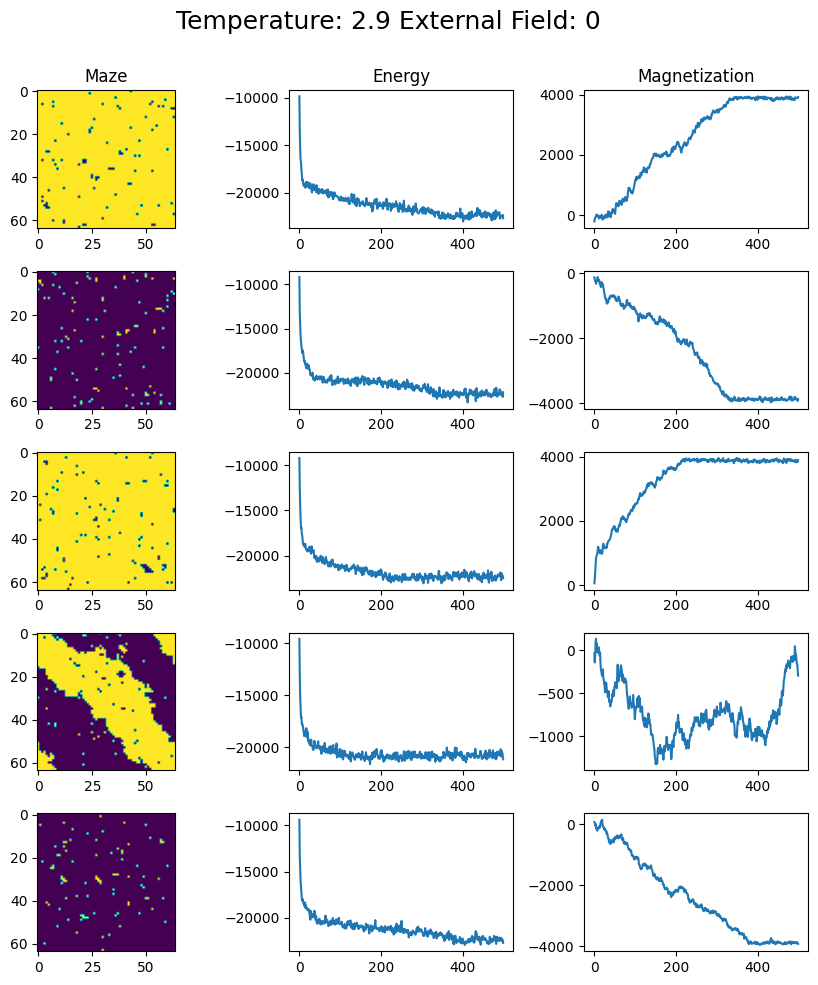

In [7]:
time_series("Rust/Demo/Crit")

## Magnetic Field Positive

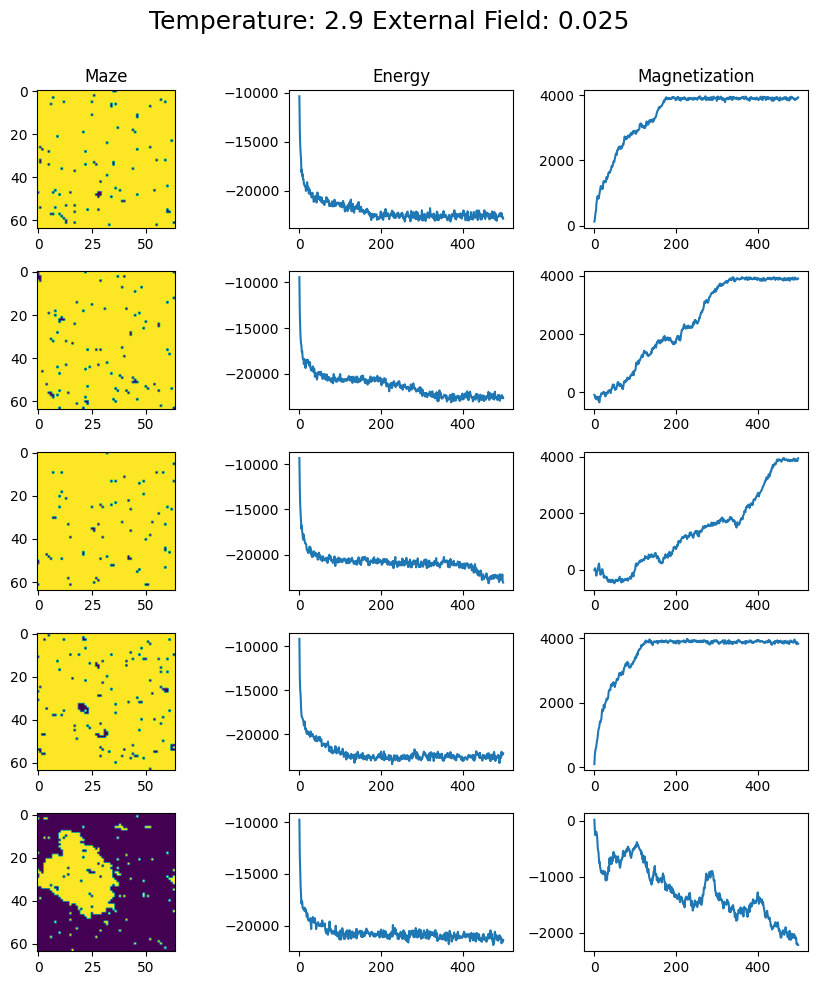

In [8]:
time_series("Rust/Demo/MagPositive/")

## Magnetic Field Negative

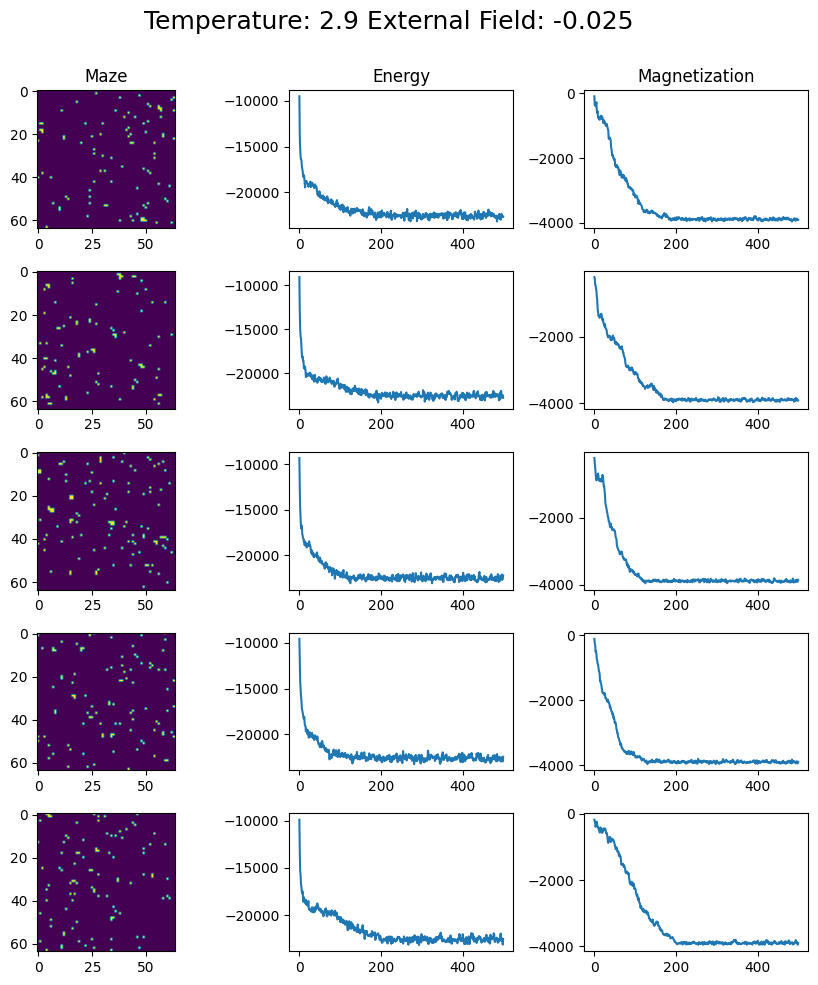

In [9]:
time_series("Rust/Demo/MagNegative/")